## Access Mooring Southern Ocean Surface Properties Realtime NonQC (Parquet)
This Jupyter notebook demonstrates how to access and plot mooring_southern_ocean_surface_properties_realtime_qc data, available as a [Parquet](https://parquet.apache.org) dataset stored on S3.

🔗 More information about the dataset is available [in the AODN metadata catalogue](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/9fdb1eee-bc28-43a9-88c5-972324784837).

📌 The source of truth for this notebook is maintained on [GitHub](https://github.com/aodn/aodn_cloud_optimised/tree/main/notebooks/mooring_southern_ocean_surface_properties_realtime_qc.ipynb).


In [1]:
dataset_name = "mooring_southern_ocean_surface_properties_realtime_qc"

## Install/Update packages and Load common functions

In [ ]:
import os, requests, importlib.util

open('setup.py', 'w').write(requests.get('https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/setup.py').text)

spec = importlib.util.spec_from_file_location("setup", "setup.py")
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

setup.install_requirements()
setup.load_dataquery()

In [2]:
from DataQuery import GetAodn

# Understanding the Dataset

## Understanding Parquet Partitioning

Parquet files can be **partitioned** by one or more columns, which means the data is physically organised into folders based on the values in those columns. This is similar to how databases use indexes to optimise query performance.

Partitioning enables **faster filtering**: when you query data using a partitioned column, only the relevant subset of files needs to be read—improving performance significantly.

For example, if a dataset is partitioned by `"site_code"`, `"timestamp"`, and `"polygon"`, filtering on `"site_code"` allows the system to skip unrelated files entirely.

In this notebook, the `GetAodn` class includes built-in methods to efficiently filter data by **time** and **latitude/longitude** using the **timestamp** and **polygon** partitions. Other partitions can be used for filtering via the `scalar_filter`.

Any filtering on columns that are **not** partitioned can be significantly slower, as all files may need to be scanned. However, the `GetAodn` class provides a `scalar_filter` method that lets you apply these filters at load time—before the data is fully read—helping reduce the size of the resulting DataFrame.

Once the dataset is loaded, further filtering using Pandas is efficient and flexible.

See further below in the notebook for examples of how to filter the data effectively.

To view the actual partition columns for this dataset, run:


In [3]:
aodn = GetAodn()
dname = f'{dataset_name}.parquet'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 131 ms, sys: 27.3 ms, total: 159 ms
Wall time: 9.38 s


In [4]:
aodn_dataset.dataset.partitioning.schema

deployment_number: int32
timestamp: int32
polygon: string

## List unique partition values

In [5]:
%%time
unique_partition_value = aodn_dataset.get_unique_partition_values('deployment_number')
print(list(unique_partition_value)[0:2])  # showing a subset only

['1', '4']
CPU times: user 13.8 ms, sys: 3.29 ms, total: 17.1 ms
Wall time: 13 ms


## Visualise Spatial Extent of the dataset
This section plots the polygons representing the areas where data is available. It helps to identify and create a bounding box around the regions containing data.

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


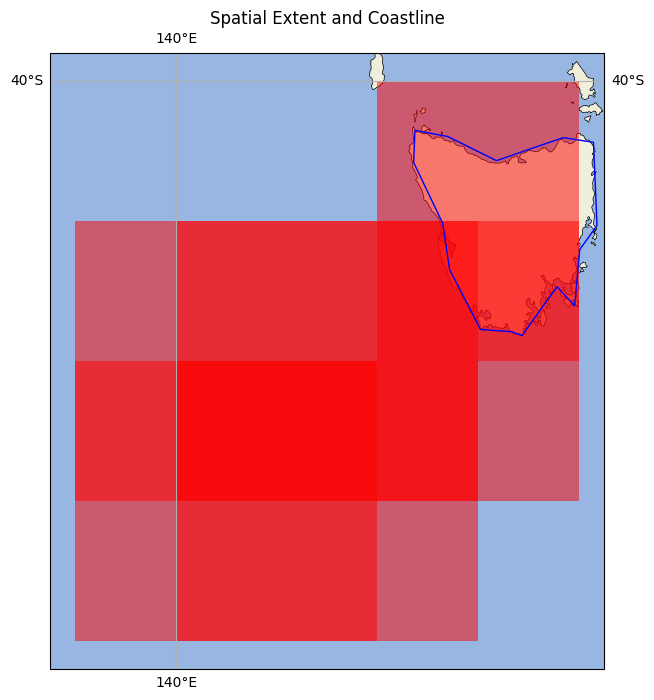

In [6]:
aodn_dataset.plot_spatial_extent()

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [7]:
%%time
aodn_dataset.get_temporal_extent()

CPU times: user 1.91 s, sys: 486 ms, total: 2.4 s
Wall time: 16 s


(Timestamp('2010-03-17 12:29:00.000016896'),
 Timestamp('2017-10-23 23:59:00.000003584'))

## Read Metadata

For all Parquet datasets, we create a sidecar file named **_common_metadata** in the root of the dataset. This file contains both the dataset-level and variable-level attributes.  
The metadata can be retrieved below as a dictionary, and it will also be included in the pandas DataFrame when using the `get_data` method from the `GetAodn` class.

In [8]:
metadata = aodn_dataset.get_metadata()
metadata

2025-10-29 14:35:19,618 - aodn.GetAodn - INFO - Retrieving metadata for imos-data-lab-optimised/mooring_southern_ocean_surface_properties_realtime_qc.parquet


{'TIME': {'type': 'timestamp[ns]',
  'standard_name': 'time',
  'long_name': 'time',
  'axis': 'T',
  'valid_min': 0,
  'valid_max': 90000.0,
  'comment': 'Relative julian days with decimal part as parts of the day',
  'ancillary_variables': 'TIME_quality_control'},
 'LATITUDE': {'type': 'float',
  'long_name': 'latitude',
  'units': 'degrees_north',
  'instrument': 'Iridium Satellite Tracker 9601-DGS-LP',
  'observation_type': 'measured',
  'standard_name': 'latitude',
  'axis': 'Y',
  'valid_min': -90,
  'valid_max': 90,
  'reference_datum': 'geographical coordinates, WGS84',
  'ancillary_variables': 'LATITUDE_quality_control'},
 'LONGITUDE': {'type': 'float',
  'long_name': 'longitude',
  'units': 'degrees_east',
  'instrument': 'Iridium Satellite Tracker 9601-DGS-LP',
  'observation_type': 'measured',
  'standard_name': 'longitude',
  'axis': 'X',
  'valid_min': -180,
  'valid_max': 180,
  'reference_datum': 'geographical coordinates, WGS84',
  'ancillary_variables': 'LONGITUDE_qua

# Data Query and Plot

## Create a TIME and BoundingBox filter

This cell loads a subset of the dataset based on a time range and a spatial bounding box. The result is returned as a pandas DataFrame, and basic information about its structure is displayed.

In [9]:
%%time
df = aodn_dataset.get_data(date_start='2010-03-18', 
                           date_end='2013-08-01',
                           lat_min=-55, 
                           lat_max=-40, 
                           lon_min=135, 
                           lon_max=160, 
                           )

df.info()

2025-10-29 14:35:52,600 - aodn.GetAodn - INFO - Retrieving metadata for imos-data-lab-optimised/mooring_southern_ocean_surface_properties_realtime_qc.parquet


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408480 entries, 0 to 408479
Data columns (total 74 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   TIME                           408480 non-null  datetime64[ns]
 1   LATITUDE                       408480 non-null  float32       
 2   LONGITUDE                      408480 non-null  float32       
 3   UWND                           314640 non-null  float32       
 4   UWND_2                         398540 non-null  float32       
 5   VWND                           314640 non-null  float32       
 6   VWND_2                         398540 non-null  float32       
 7   WDIR                           408480 non-null  float32       
 8   WDIR_2                         398540 non-null  float32       
 9   WSPD                           314640 non-null  float32       
 10  WSPD_2                         398540 non-null  float32       
 11  

In [10]:
## Download Subsetted Data as CSV

# This cell downloads the filtered dataset as a ZIP-compressed CSV file.  
# The CSV includes metadata at the top as commented lines, and a `FileLink` object is returned to allow downloading directly from the notebook.


df.aodn.download_as_csv()

/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/aodn_metadata-uuid_9fdb1eee-bc28-43a9-88c5-972324784837_mooring_southern_ocean_surface_properties_realtime_qc_data-hash_6c08dcee.csv.zip

## Create a TIME and scalar/number filter

This cell filters the dataset by time range and a scalar value (from a Parquet partition) using the `scalar_filter` argument.  
This leverages Parquet partitioning to apply efficient, server-side filtering, which significantly speeds up data loading.

In [11]:
%%time
df = aodn_dataset.get_data(
                           scalar_filter={'deployment_number': 1}
                           )

df.info()

2025-10-29 14:36:16,137 - aodn.GetAodn - INFO - Retrieving metadata for imos-data-lab-optimised/mooring_southern_ocean_surface_properties_realtime_qc.parquet


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231280 entries, 0 to 231279
Data columns (total 74 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   TIME                           231280 non-null  datetime64[ns]
 1   LATITUDE                       231280 non-null  float32       
 2   LONGITUDE                      231280 non-null  float32       
 3   UWND                           225560 non-null  float32       
 4   UWND_2                         218680 non-null  float32       
 5   VWND                           225560 non-null  float32       
 6   VWND_2                         218680 non-null  float32       
 7   WDIR                           231280 non-null  float32       
 8   WDIR_2                         218680 non-null  float32       
 9   WSPD                           225560 non-null  float32       
 10  WSPD_2                         218680 non-null  float32       
 11  

<Axes: title={'center': 'IMOS - Deep Water Moorings - Southern Ocean Flux Station (SOFS) - Surface properties (real-time)'}, xlabel='TIME', ylabel='sea_surface_temperature in celsius'>

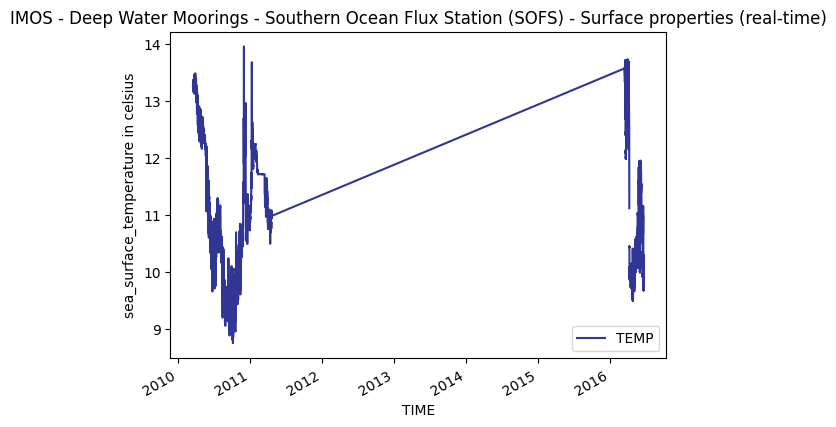

In [12]:
df.sort_values('TIME').plot(y='TEMP', x='TIME', cmap='RdYlBu_r',
                            ylabel=f"{metadata['TEMP']['standard_name']} in {metadata['TEMP']['units']}" ,
                            title=metadata['global_attributes']['title']
                           )